In [1]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import uproot
import os
import glob
from itertools import chain
from copy import deepcopy
import plotly.graph_objs as go
import plotly.express as px

In [2]:
def rotate_vec2D(vec, theta, origin=(0,0)):
 
    translated_vec = vec.translate(-origin)
    
    # Define the rotation matrix
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])

    # Apply the rotation matrix to the coordinates
    rotated_vec = np.dot(translated_vec, rotation_matrix)
    return rotated_vec.translate(origin, modify=True)

def rotate_point(px, py, cx, cy, angle):
    s = np.sin(angle)
    c = np.cos(angle)
    px -= cx
    py -= cy
    xnew = px * c - py * s
    ynew = px * s + py * c
    px = xnew + cx
    py = ynew + cy
    return px, py


def point_in_rectangle(px, py, rect):
    rx_min, rx_max = min(rect[:, 0]), max(rect[:, 0])
    ry_min, ry_max = min(rect[:, 1]), max(rect[:, 1])
    return rx_min < px < rx_max and ry_min < py < ry_max



def check_overlap(x_length, y_length, angle1, angle2, point):
    # Define the vertices of the base rectangle (centered at origin, for example)
    
    length = min((x_length, y_length))
    width = max((x_length, y_length))
    
    rect1 = np.array([[-length, -width], [length, -width], [length, width], [-length, width]])

    # Define the center
    center = (0, 0)
    
    # Apply rotation to the vertices of the second rectangle
    rect2 = np.array([rotate_point(x, y, *center, angle2) for x, y in rect1])
    rect3 = np.array([rotate_point(x, y, *center, angle1) for x, y in rect1])

    rot_point = rotate_point(point[0], point[1], *center, angle2)
    
    # Check if the point is within both rectangles
    inside_rect2 = point_in_rectangle(point[0], point[1], rect3)
    inside_rect3 = point_in_rectangle(rot_point[0], rot_point[1], rect1)

    # Determine if the point is in the overlapping area
    in_overlap = inside_rect2 and inside_rect3
    
    return in_overlap

In [3]:
class vector2D:
    
    def __init__(self, direction, anchor):
        self.direction = direction
        self.anchor = anchor
        
    def rotate(self, theta, origin=None, modify=False):
        
        if origin is None:
            origin = np.array([0, 0])   
        
        translated_vec = self.translate(-origin)
        
        rotation_matrix = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]
            ])
        
        direction = np.dot(translated_vec.direction, rotation_matrix)
        rotated_anchor = np.dot(translated_vec.anchor, rotation_matrix)
    
        anchor = rotated_anchor + origin
        
        if not modify:
            return vector2D(direction, anchor)
        
        self.direction = direction
        self.anchor = anchor
        return self
    
    def __str__(self):
        return f"vector2D: direction={self.direction} anchor={self.anchor}"
    
    def compute_intercept(self, other):
        direction_matrix = np.array([[-self.direction[0], other.direction[0]], [self.direction[1], other.direction[1]]])
        b = other.anchor - self.anchor
        
        if np.linalg.det(direction_matrix) == 0:
            print("Error: Lines are parallel")
            raise ValueError
        
        t, u = np.linalg.solve(direction_matrix, b)
        
        return self.anchor + t * self.direction
    
    def get_end(self, length):
        
        return self.anchor + (self.direction * length)
    
    def translate(self, amount, modify=False):
        
        anchor = self.anchor + amount
        
        if not modify:
            return vector2D(self.direction, anchor)

        self.anchor = anchor
        return self
    

    def distance_to_point(self, point, length):

        # Extract coordinates
        x0, y0 = point
        x1, y1 = self.anchor
        x2, y2 = self.get_end(length)
        
        # Calculate the components of the distance formula
        numerator = abs((y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2 * x1)
        denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        
        # Calculate the distance
        distance = numerator / denominator
        return distance




(-96.0, 96.0)

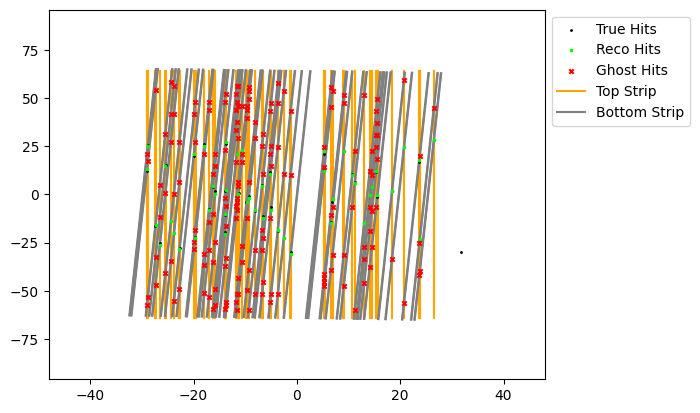

In [4]:
class SCTModule():
    
    def __init__(self, xpos=0, ypos=0, width=63.56, length=128.05, nstrips=768, stereo_angle=0.04, rotation=0, flip=False):
        
        self.xpos = 0
        self.ypos = 0
        self.width = width
        self.length = length
        self.nstrips = nstrips
        self.stereo_angle = stereo_angle
        if flip:
            self.stereo_angle *= -1
        self.rotation = 0
        
        # Init strip vectors 
        #* Baseline module: top strips are oriented vertically in the y-direction
        #*                  bottom strips are rotated by stereo angle
        vertical_unit_vec = vector2D(np.array([0, 1]), np.array(([xpos, ypos])))
        # horiz_unit_vec = vector2D(np.array([1, 1]), np.array(([xpos - width/2, ypos - length/2])))
        
        top_strips_unit_vect = vertical_unit_vec.rotate(rotation)
        bottom_strips_unit_vect = vertical_unit_vec.rotate(rotation + stereo_angle)
        
        self.top_strips = []
        self.bottom_strips = []
        
        for dx in np.linspace(-width/2, width/2, nstrips+1):
            self.top_strips.append(vertical_unit_vec.translate([dx, -length/2]).rotate(rotation, origin=np.array([xpos, ypos])))
            self.bottom_strips.append(vertical_unit_vec.translate([dx, -length/2]).rotate(rotation+stereo_angle, origin=np.array([xpos, ypos])))
        
    
    def get_hit_strips(self, hits_x, hits_y):
        
        top_hit_strip_pairs = []
        bottom_hit_strip_pairs = []
        
        for px, py in zip(hits_x, hits_y):
            distances_top = []
            distances_bottom = []
        
            if not check_overlap(self.width/2, self.length/2, self.rotation, self.rotation+self.stereo_angle, (px, py)):
                continue
            
            for strip in self.top_strips:
                strip_to_hit_distance = strip.distance_to_point([px, py], self.length)
                distances_top.append(strip_to_hit_distance)
        
            sorted_indices = np.argsort(distances_top)
            closest_lines = sorted_indices[:2]
            closest_lines = sorted(closest_lines)
            
            top_hit_strip_pairs += [[self.top_strips[l] for l in closest_lines]]
            
            for strip in self.bottom_strips:
                strip_to_hit_distance = strip.distance_to_point([px, py], self.length)
                distances_bottom.append(strip_to_hit_distance)
        
            sorted_indices = np.argsort(distances_bottom)
            closest_lines = sorted_indices[:2]
            closest_lines = sorted(closest_lines)
            
            bottom_hit_strip_pairs += [[self.bottom_strips[l] for l in closest_lines]]
            
        return top_hit_strip_pairs, bottom_hit_strip_pairs
    
    
    def get_space_points(self, hits_x, hits_y):
        
        top_hit_strip_pairs, bottom_hit_strip_pairs = self.get_hit_strips(hits_x, hits_y)
        
        x_intersection_points = []
        y_intersection_points = []
        
        space_points = set()
        space_points_x = []
        space_points_y = []
        


        for top_strip1, top_strip2 in top_hit_strip_pairs:
            for bottom_strip1, bottom_strip2 in bottom_hit_strip_pairs:
                
                is_valid = True                
                
                intercept_11 = top_strip1.compute_intercept(bottom_strip1)
                intercept_12 = top_strip1.compute_intercept(bottom_strip2)
                intercept_21 = top_strip2.compute_intercept(bottom_strip1)
                intercept_22 = top_strip2.compute_intercept(bottom_strip2)
    
                if check_overlap(self.width/2, self.length/2, self.rotation, self.rotation+self.stereo_angle, intercept_11):
                    x_intersection_points.append(intercept_11[0])
                    y_intersection_points.append(intercept_11[1])
                else:
                    is_valid = False
                
                if check_overlap(self.width/2, self.length/2, self.rotation, self.rotation+self.stereo_angle, intercept_12):
                    x_intersection_points.append(intercept_12[0])
                    y_intersection_points.append(intercept_12[1])
                else:
                    is_valid = False
                
                if check_overlap(self.width/2, self.length/2, self.rotation, self.rotation+self.stereo_angle, intercept_21):
                    x_intersection_points.append(intercept_21[0])
                    y_intersection_points.append(intercept_21[1])
                else:
                    is_valid = False
                
                if check_overlap(self.width/2, self.length/2, self.rotation, self.rotation+self.stereo_angle, intercept_22):
                    x_intersection_points.append(intercept_22[0])
                    y_intersection_points.append(intercept_22[1])
                else:
                    is_valid = False
                
                if is_valid:
                    sp_x = (intercept_11[0] + intercept_12[0] + intercept_21[0] + intercept_22[0]) / 4
                    sp_y = (intercept_11[1] + intercept_12[1] + intercept_21[1] + intercept_22[1]) / 4
                    
                    # if sp_x not in space_points_x and sp_y not in space_points_y: 
                    space_points.add((sp_x, sp_y))

        space_points_x = [xy[0] for xy in space_points]
        space_points_y = [xy[1] for xy in space_points]
        
        return (space_points_x, space_points_y), (top_hit_strip_pairs, bottom_hit_strip_pairs), (x_intersection_points, y_intersection_points)

    
    def sort_hits_from_ghosts(self, hits_x, hits_y, space_points_x, space_points_y):
        
        ghost_hits_x = deepcopy(space_points_x)
        ghost_hits_y = deepcopy(space_points_y)
        
        reco_hits_x = []
        reco_hits_y = []
        
        for i, (px, py) in enumerate(zip(hits_x, hits_y)):
            smallest_distance = 10e10
            
            if not check_overlap(self.width/2, self.length/2, self.rotation, self.rotation+self.stereo_angle, (px, py)):
                continue
            
            best_idx = 0
            for j, (sx, sy) in enumerate(zip(ghost_hits_x, ghost_hits_y)):
                
                distance = np.sqrt((px - sx)**2 + (py - sy)**2)
                
                if distance < smallest_distance:
                    smallest_distance = distance
                    best_idx = j
            
            if len(ghost_hits_x) != 0 :
                reco_hits_x.append(ghost_hits_x.pop(best_idx))
                reco_hits_y.append(ghost_hits_y.pop(best_idx))
        
        return (np.array(reco_hits_x), np.array(reco_hits_y)), (np.array(ghost_hits_x), np.array(ghost_hits_y))
    

    def get_reco_and_ghost_hits(self, hits_x, hits_y):
        
        (space_points_x, space_points_y), (top_hit_strip_pairs, bottom_hit_strip_pairs), _ = self.get_space_points(hits_x, hits_y)
        
        (reco_hits_x, reco_hits_y), (ghost_hits_x, ghost_hits_y) = self.sort_hits_from_ghosts(hits_x, hits_y, space_points_x, space_points_y)
        
        return (reco_hits_x, reco_hits_y), (ghost_hits_x, ghost_hits_y), (top_hit_strip_pairs, bottom_hit_strip_pairs)
    
    
    def draw_hits(self, ax, hits_x, hits_y):
        
        (reco_hits_x, reco_hits_y), (ghost_hits_x, ghost_hits_y), (top_hit_strip_pairs, bottom_hit_strip_pairs) = self.get_reco_and_ghost_hits(hits_x, hits_y)
        
        ax.scatter(hits_x, hits_y, color='black', s=1, zorder=10, label="True Hits")
        ax.scatter(reco_hits_x, reco_hits_y, color='lime', marker='.', s=10, zorder=10, label="Reco Hits")
        ax.scatter(ghost_hits_x, ghost_hits_y, color='red', marker='x',s=10, zorder=10, label="Ghost Hits")
        
        for strip in list(chain.from_iterable(top_hit_strip_pairs)):  # Need to flatten list of strip pairs
            strip_1x = strip.anchor[0]
            strip_1y = strip.anchor[1]
            strip_2x = strip.get_end(self.length)[0]
            strip_2y = strip.get_end(self.length)[1]
        
            ax.plot([strip_1x, strip_2x], [strip_1y, strip_2y], color='orange', label="Top Strip")
        
        for strip in list(chain.from_iterable(bottom_hit_strip_pairs)):
            strip_1x = strip.anchor[0]
            strip_1y = strip.anchor[1]
            strip_2x = strip.get_end(self.length)[0]
            strip_2y = strip.get_end(self.length)[1]
        
            ax.plot([strip_1x, strip_2x], [strip_1y, strip_2y], color='grey', label="Bottom Strip")
    
    
    def draw_module(self, ax):
    
        for strip in self.top_strips:
            strip_1x = strip.anchor[0]
            strip_1y = strip.anchor[1]
            strip_2x = strip.get_end(self.length)[0]
            strip_2y = strip.get_end(self.length)[1]
        
            ax.plot([strip_1x, strip_2x], [strip_1y, strip_2y], color='orange', label="Top Strip")
        
        for strip in self.bottom_strips:
            strip_1x = strip.anchor[0]
            strip_1y = strip.anchor[1]
            strip_2x = strip.get_end(self.length)[0]
            strip_2y = strip.get_end(self.length)[1]
        
            ax.plot([strip_1x, strip_2x], [strip_1y, strip_2y], color='blue', label="Bottom Strip")
        
        # ax.set_xlim(-32, 32)
        # ax.set_ylim(-64, 64)
        # ax.scatter(intercept[0], intercept[1], label="Intercept")
        # ax.legend()
        ax.set_title(f"Rotation = {self.rotation:.3f}", fontsize=10, loc='right')
        
        return ax
        

mod1 = SCTModule(rotation=0)

fig, ax = plt.subplots()
# mod1.draw_module(ax)

# SCTModule(nstrips=50, rotation=np.pi/2)
# SCTModule(nstrips=50, rotation=0, stereo_angle=-0.04)
# SCTModule(nstrips=50, rotation=np.pi/2, stereo_angle=-0.04)

       
sct_width=63.56 
sct_length=128.05
np.random.seed(41)
n = 50
rpx = np.random.rand(n) * sct_width - sct_width/2
rpy = np.random.rand(n) * sct_width - sct_width/2

mod1.draw_hits(ax, rpx, rpy)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1, 1))
ax.set_xlim(-32*1.5, 32*1.5)
ax.set_ylim(-64*1.5, 64*1.5)

In [18]:
def sort_events(events_arr):
    index = ak.argsort([len(events_arr['x'][i]) for i in range(len(events_arr['x']))])
    return events_arr[index]


In [19]:
data = uproot.open("/home/bewilson/FASERvSi_G4/GeantOutput/FASERvSiBaseline-LightTrench-680fb.root:Hits")
events = data.arrays(data.keys())

In [31]:

cc_data = events[events['isCC'] == True]
nc_data = events[events['isCC'] == True]
cc_el_data = events[abs(events['nu_pdgc']) == 12]
cc_mu_data = events[abs(events['nu_pdgc']) == 14]


nc_data_sorted = sort_events(nc_data)
cc_el_data_sorted = sort_events(cc_el_data)
cc_nu_data_sorted = sort_events(cc_mu_data)

event = nc_data_sorted[-1]
z_pos = set(np.floor(ak.sort(event['z'])))

z_pos = np.sort(list(z_pos))

# print(z_pos)
initial_layer_num = min(z_pos)

counter = 0
cutoff = 100

hits_x_dict = {p : [] for p in z_pos}
hits_y_dict = {p : [] for p in z_pos}
hits_z_dict = {p : [] for p in z_pos}

tmp_x = []
tmp_y = []
tmp_z = []

for x, y, z, l in zip(event['x'], event['y'], event['z'], event['layer']):    
    
    hits_x_dict[z].append(x)
    hits_y_dict[z].append(y)
    hits_z_dict[z].append(z)

hits_x = [x for x in hits_x_dict.values()]
hits_y = [x for x in hits_y_dict.values()]
hits_z = [x for x in hits_z_dict.values()]


hits_x = ak.Array(hits_x)
hits_y = ak.Array(hits_y)
hits_z = ak.Array(hits_z)

def centre_hits(hits, vtx):
    hits_cent = hits - vtx
    return hits_cent

hits_x_centred = centre_hits(hits_x, event['vertex_x'])
hits_y_centred = centre_hits(hits_y, event['vertex_y'])
hits_z_centred = centre_hits(hits_z, event['vertex_z'])

KeyError: np.float64(550.45)

In [17]:
# modules = [SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True)]
# modules  += modules + modules + modules

# fig, ax = plt.subplots()
# for i, module in enumerate(modules):
#     (reco_1x, reco_1y),   (ghosts_1x, ghosts_1y), _ = module.get_reco_and_ghost_hits(hits_x_centred[i], hits_y_centred[i])
#     ax.scatter(reco_1x, reco_1y, color='blue', marker='^', label='Reco Hits Module 1', alpha=0.1)
#     ax.scatter(ghosts_1x, ghosts_1y, color='orange', marker='x', label='Ghost Hits Module 1', alpha=0.1)

In [32]:
modules = [SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           SCTModule(), SCTModule(rotation=np.pi/2), SCTModule(flip=True), SCTModule(rotation=np.pi/2, flip=True), 
           ]

scatter = []
for i, module in enumerate(modules):
    (reco_x, reco_y), (ghosts_x, ghosts_y), _ = module.get_reco_and_ghost_hits(hits_x_centred[i], hits_y_centred[i])
    
    if i < 8:
        continue
    
    print(i, hits_x_centred[i], reco_x, hits_z[i])
    scatter.append(go.Scatter3d(x=hits_x_centred[i].tolist(), y=hits_y_centred[i].tolist(), z=hits_z[i].tolist(), mode='markers',  marker=dict( size=5, color='green', opacity=0.5)))
    scatter.append(go.Scatter3d(x=reco_x.tolist(), y=reco_y.tolist(), z=hits_z[i].tolist(), mode='markers',  marker=dict( size=5, color='blue', opacity=1)))
    scatter.append(go.Scatter3d(x=ghosts_x.tolist(), y=ghosts_y.tolist(), z=hits_z[i].tolist(), mode='markers',  marker=dict( size=5, color='red', opacity=1)))
    scatter.append(go.Scatter3d(x=[0], y=[0], z=hits_z[i].tolist(), mode='markers',  marker=dict( size=5, color='black', opacity=1)))

fig = go.Figure(data=scatter)
# Customize the layout
fig.update_layout(
    title="",
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    ),
    width=1200, # Set the width here 
    height=800, # Set the height here
    # xaxis=dict(range=(-64/2, 64/2)), # Change the x-axis range 
    # yaxis=dict(range=(-64/2, 64/2)),
)

fig.show()
    

8 [-35.5] [] [581]
9 [-10.9, 0.114, 0.178, -0.556, 10.8, ..., 0.135, -0.0298, -0.067, -0.0988] [] [582, 582, 582, 582, 582, 582, 582, 582, 582, 582]
10 [-33.6] [] [589]
11 [-13.4, 0.142, 0.169, -0.688, 13.9, ..., 0.168, -0.0371, -0.0834, -0.123] [] [590, 590, 590, 590, 590, 590, 590, 590, 590, 590]
